In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Plot for regression

In [2]:
Path = '../../data/firstRound_Microplate_normTrue_formatSeq_logTrue.csv'

df = pd.read_csv(Path)
df.head(20)

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,1.616261,1.814182,1.760954,2.186207,2.028863,1.831982,1.881293,0.225819
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,1.166174,1.337018,1.417248,1.493800,1.713526,1.644568,1.425553,0.201725
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,0.604551,0.751384,0.851987,0.514929,0.577299,0.795227,0.660030,0.137994
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,1.221264,1.466278,1.270212,1.341040,1.395030,1.175433,1.338765,0.097386
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,1.160566,1.579025,1.171829,1.590670,1.411255,1.756862,1.382669,0.210012
5,5,RBS_1by1_5,bps_noncore,TGTAAGAAGGAGATATACAT,AGGAGA,0.288674,0.268222,0.486638,0.254308,0.342162,0.501763,0.328001,0.094759
6,6,RBS_1by1_6,bps_noncore,TATAAGAAGGAGATATACAT,AGGAGA,1.003687,1.116599,0.851400,0.866754,1.075506,1.462978,0.982789,0.120068
7,8,RBS_1by1_8,bps_noncore,TTGAAGAAGGAGATATACAT,AGGAGA,1.138820,1.342549,NaN,1.626269,1.423415,1.806580,1.382763,0.201720
8,9,RBS_1by1_9,bps_noncore,TTAAAGAAGGAGATATACAT,AGGAGA,0.508605,0.646307,1.153507,0.488646,0.406578,0.583543,0.640728,0.299326
9,10,RBS_1by1_10,bps_noncore,TTTCAGAAGGAGATATACAT,AGGAGA,1.119059,0.876151,0.624684,1.321343,1.066000,1.621663,1.001447,0.263620


Refer to [Gaussian process regression (GPR) with noise-level estimation](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html)  
with alpha only: predict different values for the same sequence  
with WhiteKernel: predict same values for the same sequence

X train shape:  (845, 20)
X test shape:  (35, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fb6b490fb70>
Train:  0.14702398942845965
Test:  0.45112109113670257
<function r2_score at 0x7fb6b490fd90>
Train:  0.8231389240544349
Test:  0.20435533011685592


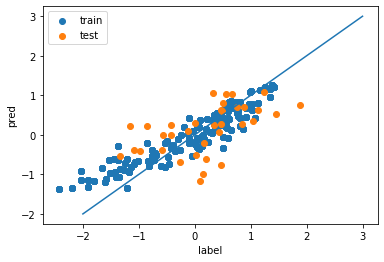

In [3]:
kernel = 'WD_Kernel_Shift'
embedding = 'label'
eva_metric = [mean_squared_error, r2_score]

gpr_train_samples = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
                   l = 6, s = 0, alpha = 2, eva_on='seqs')
gpr_train_samples.regression()
gpr_train_samples.scatter_plot()

In [4]:
gpr_train_samples.gp_reg.kernel_

WD_Shift_Kernel() + WhiteKernel(noise_level=1e-05)

In [5]:
gpr_train_samples.train_df

,RBS,RBS6,AVERAGE,STD,Group,variable,label,pred mean,pred std
0,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep1,1.166174,1.199791,0.400688
1,ATTAAGAAGGAGATATACAT,AGGAGA,1.338765,0.097386,bps_noncore,Rep1,1.221264,1.147126,0.400688
2,TCTAAGAAGGAGATATACAT,AGGAGA,1.382669,0.210012,bps_noncore,Rep1,1.160566,1.245410,0.421245
3,TATAAGAAGGAGATATACAT,AGGAGA,0.982789,0.120068,bps_noncore,Rep1,1.003687,1.082526,0.421245
4,TTGAAGAAGGAGATATACAT,AGGAGA,1.382763,0.201720,bps_noncore,Rep1,1.138820,1.226456,0.452072
...,...,...,...,...,...,...,...,...,...
841,TTTAAGATAAGGGTATACAT,TAAGGG,0.564876,0.143604,prob random,Rep6,0.432208,0.208296,0.400875
842,TTTAAGATAGTCTTATACAT,TAGTCT,0.585487,0.184425,prob random,Rep6,0.260032,0.181403,0.447624
843,TTTAAGAAAGTAGTATACAT,AAGTAG,0.380490,0.159538,prob random,Rep6,-0.182145,0.124577,0.442977
844,TTTAAGAGTAATGTATACAT,GTAATG,0.244736,0.169817,prob random,Rep6,-0.036484,-0.178620,0.445139


In [6]:
gpr_train_samples.train_df[gpr_train_samples.train_df['RBS'] == 'CTTAAGAAGGAGATATACAT']

,RBS,RBS6,AVERAGE,STD,Group,variable,label,pred mean,pred std
0,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep1,1.166174,1.199791,0.400688
141,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep2,1.337018,1.199791,0.400688
282,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep3,1.417248,1.199791,0.400688
423,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep4,1.493800,1.199791,0.400688
564,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep5,1.713526,1.199791,0.400688
705,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep6,1.644568,1.199791,0.400688


In [7]:
gpr_train_samples.test_df[gpr_train_samples.test_df['RBS'] == 'TTTAAGATAAGATTATACAT']

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD,label,pred mean,pred std
108,109,RBS_BA_19,bandit,TTTAAGATAAGATTATACAT,TAAGAT,-0.440723,-1.407786,-1.373892,-2.035393,-0.553289,-0.662509,-1.162217,0.663116,-1.162217,0.23511,0.555201


In [8]:
wd_kernel =  WD_Shift_Kernel(l = 6, features = gpr_train_samples.features, s = 1)
#kernel_matrix_samples = wd_kernel.cal_kernel(np.asarray(gpr_train_samples.train_df['RBS']), np.asarray(gpr_train_samples.train_df['RBS']))
#np.linalg.eig(kernel_matrix)
kernel_matrix_samples = wd_kernel.kernel_all_normalised

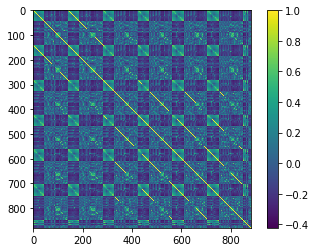

In [9]:
plt.imshow(kernel_matrix_samples)
plt.colorbar()

In [10]:
kernel_matrix_samples[0].all() == kernel_matrix_samples[141].all()

True

In [11]:
np.linalg.eigh(kernel_matrix_samples)

(array([-3.18586911e-12, -1.13028436e-14, -9.89651829e-15, -8.34130819e-15,
        -7.39460318e-15, -6.61651577e-15, -6.44045206e-15, -6.32579952e-15,
        -5.75672782e-15, -5.21015994e-15, -5.00236981e-15, -4.74519799e-15,
        -4.53619392e-15, -4.47736191e-15, -4.19745055e-15, -4.12110896e-15,
        -4.10397468e-15, -3.66886589e-15, -3.47163275e-15, -3.38842534e-15,
        -3.22500641e-15, -3.11590919e-15, -2.96915495e-15, -2.96537162e-15,
        -2.76477057e-15, -2.74053239e-15, -2.56814328e-15, -2.50993149e-15,
        -2.48530376e-15, -2.42496078e-15, -2.39053556e-15, -2.37098728e-15,
        -2.20426585e-15, -2.17900655e-15, -2.14064718e-15, -2.09964430e-15,
        -2.00383086e-15, -1.95682167e-15, -1.90669058e-15, -1.82589380e-15,
        -1.78858107e-15, -1.73713343e-15, -1.68934435e-15, -1.68354419e-15,
        -1.67236400e-15, -1.64473982e-15, -1.64419720e-15, -1.62470887e-15,
        -1.60663582e-15, -1.59510782e-15, -1.56447652e-15, -1.53205093e-15,
        -1.5

In [12]:
one_vec = np.ones((kernel_matrix_samples.shape[0],1))
one_mat = np.ones(kernel_matrix_samples.shape)
row_sum = np.mean(kernel_matrix_samples,axis=0).T
K = kernel_matrix_samples - (row_sum * one_vec.T + one_vec * row_sum.T -np.mean(row_sum)*one_mat)

In [13]:
kernel_matrix_samples

array([[ 1.        ,  0.82058929,  0.68397772, ..., -0.25199747,
         0.50393966,  0.82077242],
       [ 0.82058929,  1.        ,  0.68397772, ..., -0.25199747,
         0.50393966,  0.82077242],
       [ 0.68397772,  0.68397772,  1.        , ..., -0.23132648,
         0.44697212,  0.68419516],
       ...,
       [-0.25199747, -0.25199747, -0.23132648, ...,  1.        ,
        -0.20532141, -0.25088308],
       [ 0.50393966,  0.50393966,  0.44697212, ..., -0.20532141,
         1.        ,  0.50426698],
       [ 0.82077242,  0.82077242,  0.68419516, ..., -0.25088308,
         0.50426698,  1.        ]])

In [14]:
kernel_matrix_samples.shape

(880, 880)

X train shape:  (845, 20)
X test shape:  (35, 20)
create kernel instance
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7fb6b490fb70>
Train:  0.04096698247202578
Test:  0.529197654302131
<function r2_score at 0x7fb6b490fd90>
Train:  0.9507191674881659
Test:  0.0666512800383301


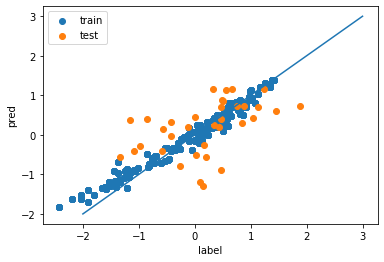

In [15]:
kernel = 'WD_Kernel_Shift'
embedding = 'label'
eva_metric = [mean_squared_error, r2_score]

gpr_train_seqs = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
                   l = 6, s = 0, alpha = 0.5, eva_on='seqs')
gpr_train_seqs.regression()
gpr_train_seqs.scatter_plot()

In [16]:
gpr_train_seqs.test_df

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD,label,pred mean,pred std
108,109,RBS_BA_19,bandit,TTTAAGATAAGATTATACAT,TAAGAT,-0.440723,-1.407786,-1.373892,-2.035393,-0.553289,-0.662509,-1.162217,0.663116,-1.162217,0.381969,0.478445
159,161,RBS_RP_41,prob random,TTTAAGATACTGATATACAT,TACTGA,0.381380,0.686505,0.504649,0.206063,0.418553,0.138494,0.439430,0.175760,0.439430,0.201934,0.684689
93,94,RBS_BA_04,bandit,TTTAAGAGCCGGATATACAT,GCCGGA,0.575108,0.631228,0.484304,0.445865,0.200938,-0.034606,0.467489,0.165976,0.467489,0.394466,0.526326
151,153,RBS_RP_33,prob random,TTTAAGACCGGGATATACAT,CCGGGA,-0.911192,-0.659232,-0.322793,-0.385093,-1.967401,-1.095854,-0.849142,0.667608,-0.849142,0.393076,0.732287
57,58,RBS_1by1_58,bps_noncore,TTTAAGAAGGAGATATACAC,AGGAGA,0.855386,0.772457,0.714765,1.130928,0.958318,1.408394,0.886371,0.164598,0.886371,0.717508,0.501263
26,27,RBS_1by1_27,bps_core,TTTAAGAATGAGATATACAT,ATGAGA,-0.579086,-0.474276,0.022355,-0.561411,-0.547485,-1.840800,-0.427981,0.254884,-0.427981,-0.020458,0.676801
112,114,RBS_BA_24,bandit,TTTAAGAGGGGGATATACAT,GGGGGA,0.405390,0.830303,1.117253,1.315338,1.568453,1.176796,1.047348,0.449298,1.047348,0.437882,0.603389
78,79,RBS_RU_18,uni random,TTTAAGAACCGTGTATACAT,ACCGTG,-0.233672,-0.797632,-0.396004,-0.789864,-0.721970,-0.931346,-0.587828,0.257417,-0.587828,-0.409830,0.587925
25,26,RBS_1by1_26,bps_core,TTTAAGAAAGAGATATACAT,AAGAGA,0.011928,-0.155133,0.990007,-0.429727,-0.371476,-0.081111,0.009120,0.575883,0.009120,0.441115,0.633747
88,89,RBS_RU_28,uni random,TTTAAGACGAGACTATACAT,CGAGAC,-0.030545,-0.286107,0.099052,-0.459366,0.103592,-0.110506,-0.114675,0.249298,-0.114675,0.189190,0.533773


## Repeated KFold

In [17]:
import pickle

with open('kflod_results/repeated_kfold_wd_shift_logTrue_evaSeq.pickle', 'rb') as handle:
    result_pkl = pickle.load(handle)

In [18]:
import xarray
result_test_s0_aveSplit_aveRepeat = result_pkl[1].loc[dict(s = 0)].mean(axis = -1).mean(axis = -1)
result_test_s1_aveSplit_aveRepeat = result_pkl[1].loc[dict(s = 1)].mean(axis = -1).mean(axis = -1)
result_test_s2_aveSplit_aveRepeat = result_pkl[1].loc[dict(s = 2)].mean(axis = -1).mean(axis = -1)

In [19]:
result_test_s0_aveSplit_aveRepeat

<xarray.DataArray (alpha: 21, l: 4)>
array([[1.26233808, 1.21934278, 1.22246368, 1.10961882],
       [0.87459999, 0.87055171, 0.89713976, 0.85547907],
       [0.80702986, 0.83542606, 0.7892894 , 0.79315209],
       [0.79325253, 0.78738795, 0.77396435, 0.75315738],
       [0.7807854 , 0.79277263, 0.74850416, 0.74925239],
       [0.78557403, 0.76527113, 0.75953693, 0.74250648],
       [0.77974293, 0.7499474 , 0.75541773, 0.73589765],
       [0.76827697, 0.76355223, 0.75677268, 0.76297781],
       [0.77190605, 0.755155  , 0.74417191, 0.73820289],
       [0.76817021, 0.7678082 , 0.74778035, 0.7373879 ],
       [0.76324691, 0.76190945, 0.74107088, 0.73617823],
       [0.77021022, 0.75805215, 0.75020015, 0.75312134],
       [0.77042698, 0.76062137, 0.75078407, 0.74486233],
       [0.78048303, 0.75572055, 0.74794436, 0.74768476],
       [0.7685245 , 0.75632756, 0.74770342, 0.74510788],
       [0.76589546, 0.76415929, 0.74522604, 0.74827753],
       [0.77253683, 0.76538293, 0.74385624, 0.74639469],
       [0.77443947, 0.76357087, 0.7573345 , 0.74543478],
       [0.76844234, 0.7607419 , 0.74840374, 0.74997674],
       [0.77345261, 0.76044826, 0.75561943, 0.75037812],
       [0.76387207, 0.76333613, 0.75403397, 0.75108625]])
Coordinates:
    train_test  <U5 'Test'
  * alpha       (alpha) int64 1 10 20 30 40 50 60 ... 150 160 170 180 190 200
  * l           (l) <U3 '[3]' '[4]' '[5]' '[6]'
    s           int64 0

In [20]:
result_test_s0_aveSplit_aveRepeat.coords['l'] = [3,4,5,6]
result_test_s1_aveSplit_aveRepeat.coords['l'] = [3,4,5,6]
result_test_s2_aveSplit_aveRepeat.coords['l'] = [3,4,5,6]

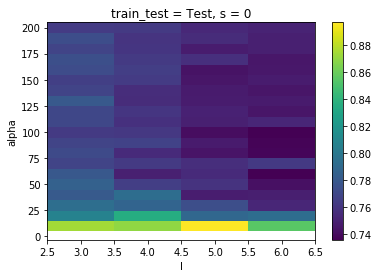

In [21]:
result_test_s0_aveSplit_aveRepeat.where(result_test_s0_aveSplit_aveRepeat < 1).plot()

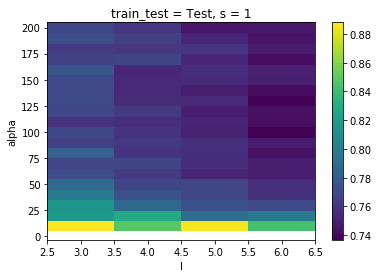

In [22]:
result_test_s1_aveSplit_aveRepeat.where(result_test_s1_aveSplit_aveRepeat < 1).plot()

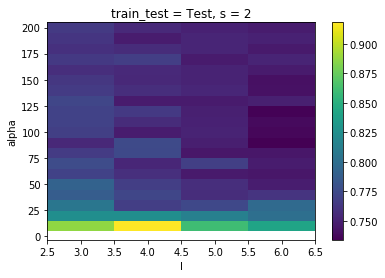

In [23]:
result_test_s2_aveSplit_aveRepeat.where(result_test_s2_aveSplit_aveRepeat < 1).plot()

In [24]:
# average mean square error for testing 

result_pkl[1].loc[dict(s = 1)].loc[dict(l = '[6]')].mean(axis = -1).mean(axis = -1)

<xarray.DataArray (alpha: 21)>
array([1.1512797 , 0.84359855, 0.79909973, 0.77068351, 0.75755586,
       0.75657694, 0.74872428, 0.74963607, 0.74386427, 0.74837986,
       0.73680298, 0.74181425, 0.74306736, 0.73768472, 0.74125225,
       0.75029304, 0.75087085, 0.74175137, 0.74907985, 0.74476065,
       0.74683378])
Coordinates:
    train_test  <U5 'Test'
  * alpha       (alpha) int64 1 10 20 30 40 50 60 ... 150 160 170 180 190 200
    l           <U3 '[6]'
    s           int64 1

In [25]:
# std of mean square error for testing

result_pkl[1].loc[dict(s = 1)].loc[dict(l = '[6]')].mean(axis = -1).std(axis = -1)

<xarray.DataArray (alpha: 21)>
array([0.09969509, 0.02697518, 0.04492847, 0.02948356, 0.02706565,
       0.0233904 , 0.02620881, 0.02209315, 0.02025293, 0.01341702,
       0.01194087, 0.02283254, 0.01004528, 0.01353901, 0.01234023,
       0.01097683, 0.01417145, 0.01417162, 0.02050755, 0.00907089,
       0.00887418])
Coordinates:
    train_test  <U5 'Test'
  * alpha       (alpha) int64 1 10 20 30 40 50 60 ... 150 160 170 180 190 200
    l           <U3 '[6]'
    s           int64 1